# Full Feature Extraction Routine

In this notebook, I will finalize the feature extraction algorithm, and link each part to the existing literature on logos and design, where relevant. 

## Preliminary: load required functions

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image

from skimage import measure, io, color, feature, morphology
from skimage.transform import resize, rescale
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import convex_hull_image, disk
from skimage.filters.rank import entropy

from scipy.stats import mode
from sklearn.cluster import DBSCAN, KMeans

from collections import OrderedDict

try:
    os.chdir("/media/ryan/hdd/Dropbox/1_proj/logos/code/extract_features/")
except:
    os.chdir("/Users/ryan/Dropbox/1_proj/logos/code/extract_features/")

from segmentation_functions import *

try:
    os.chdir("/media/ryan/hdd/Dropbox/1_proj/logos/")
except:
    os.chdir("/Users/ryan/Dropbox/1_proj/logos/")

## Load and pre-process the logo:

In [2]:
logodata = pd.read_csv("data/new_sources/final_cleaned.csv")
logodata.iloc[43,:]

name                                                          amgen
include                                                           0
url                                           http://www.amgen.com/
brand_identity    Amgen is one of the world's leading biotechnol...
source                                                           BD
cb_id                                                       amgen-2
cb_desc           Amgen is one of the world's leading biotechnol...
logo_file                                                 amgen.jpg
logo_url           http://www.columbia.edu/~rtd2118/logos/amgen.jpg
Name: 43, dtype: object

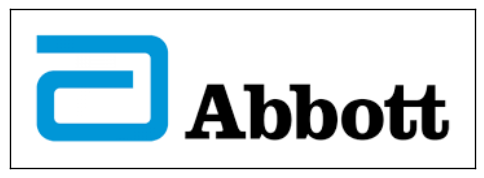

In [3]:
logo = 'abbott-labs.png'
name = logo.split(".")[0]

img = io.imread("data/new_sources/logos/" + logo)
img = standardize(img)
img = remove_white_bg(img)
img = add_padding(img, bgval=255)
#img = np.floor(255*rescale_img(img, tot_pix=20000)).astype('uint8')

fig = plt.figure()
plt.imshow(img)
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                labelbottom='off', right='off', left='off', labelleft='off')

## Segment the image and isolate characters

In this version, we will first segment by color. Then we will template match with the font dictionary, and isolate anything that resembles a character. Then we will study the remainder, which should correspond to marks.

*Segment the image by color regions:*

In [4]:
quantized, centers, color_df = hsv_segmentation(img, name="name")
small_feats, feat_cols, areas, fracs, regionalized = extract_features(quantized, centers)

color_df

,name,area,frac,r,g,b
0,name,4531,0.102326,1.311410,150.069080,215.018318
1,name,34734,0.784417,254.302499,254.526429,254.630880
2,name,4173,0.094241,2.889049,2.889049,2.889049
3,name,842,0.019015,139.399050,164.022565,176.038005


In a separate file, these colors will be clustered and made into a color dictionary. Note that there has been a huge amount of research about color and color preferences, in marketing and psychology. For example, Deng et al. (2010) study preferences for color combinations, showing that people tend to prefer similar colors in a logo, but with an accent color, and that people prefer a small number of colors. Other work by Kareklas et al. (2014) shows that people have an automatic preference for white over black in ads, and Semin and Palma (2014) find that white is perceived as feminine, while black is perceived as masculine. Note that this may also be turned into a feature, as the percentage of white space in the logo, later on. 

Note that something we are not currently doing is looking much at HSV properties, but a lot of work, for example by Valdez and Mehrabian (1994), does study HSV dimensions.

*Look at what small features are isolated:*

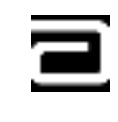

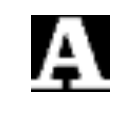

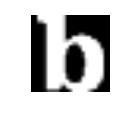

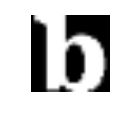

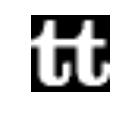

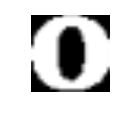

In [5]:
for s in range(small_feats.shape[2]):
    plt.figure(figsize=(1,1))
    plt.imshow(small_feats[:,:,s], cmap='gray')
    plt.axis('off')

*Load the font dictionary:*

In [6]:
fontdf = pd.read_csv("data/labeled_fonts_amp_wide.csv")
fontmat = fontdf.iloc[:,0:625].values.astype('float')

*Match features to fonts:*

In [7]:
is_char, char_match, otherthing = detect_chars(small_feats, fontdf, name=name)

In computing this match, we are matching each feature to a member of the font dictionary in `fontdf`. This process tracks various features of the fonts, including an approximate font family (including generic families like serif/sans), a font class (from the ATypI classification scheme), font style (italics or normal), font spacing (condensed or not), and font weight (bold or not). Font is something that is focal for designers, and has also been studied in the literature. Doyle and Bottomley (2006) published a paper giving a bit of an overview, where the main takeaway appears to be that the font should match the brand. More interesting for this project is Henderson et al. (2004), where they describe fonts both in terms of the traits described above (weight, spacing, style, etc.), and also in terms of more abstract dimensions (elaborateness, naturalness, harmony). Their work links the explicit aspects of font to a bunch of subdimensions, which may be useful for us. They also give nice examples toward the end.

In [8]:
brand_font_df = fontdf.iloc[char_match[char_match < 9999.].astype('int'),625:]
brand_font_df.insert(0, 'name', name)
brand_font_df.insert(1, 'match', char_match[char_match < 9999.].astype('int'))

brand_font_df

,name,match,ftype,style,family,ver,letter
4206,abbott-labs,4206,serif,oldstyle,bembo,bold,a
3199,abbott-labs,3199,serif,clarendon,clarendon,bold,b
3199,abbott-labs,3199,serif,clarendon,clarendon,bold,b
3174,abbott-labs,3174,serif,clarendon,clarendon,bold,o


*Isolate the part of the image that corresponds to the characters:*

In [9]:
allchars = np.isin(regionalized-1, np.where(is_char))

## Isolating the marks

Note that in this step, we use the convex hull of the characters, not the characters themselves, to avoid leaving behind the "insides" of some letters like e, o, P, R, etc.

In [10]:
marks = np.copy(regionalized)
if np.sum(is_char) > 0:
    for j in np.nditer(np.where(is_char)):
        ch = convex_hull_image(((regionalized-1)==j).astype('float'))
        marks[ch] = 0

*Plot the results:*

(-0.5, 399.5, 162.5, -0.5)

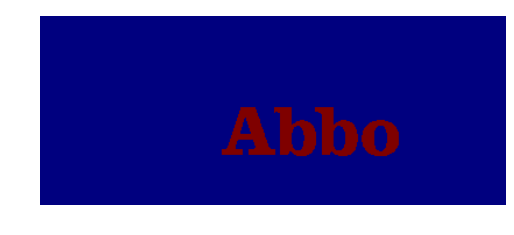

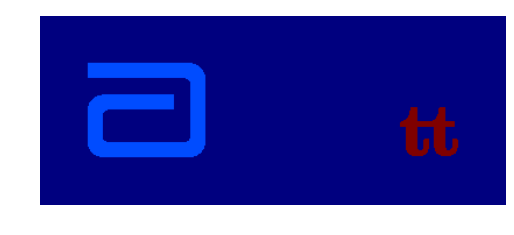

In [11]:
plt.figure()
plt.imshow(allchars)
plt.axis('off')

plt.figure()
plt.imshow(marks)
plt.axis('off')

### Erosion to separate characters

One remaining problem is that we may have characters that are not totally separate, due to just how the font was set. For example, two letters touching or almost touching, like "tu" as typeset here.

To try to separate these out, we can apply an erosion step, where we erode the remaining marks, and then try to template match again. 

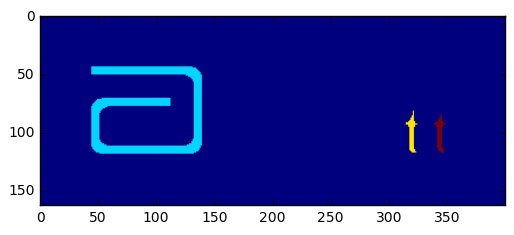

In [12]:
eroded = morphology.erosion(marks>0, selem=morphology.disk(3)) # 3 is a tuning par (so is disk actually)
eroded_labels = label(eroded)
plt.imshow(eroded_labels)

In [13]:
eroded_segmentation = np.zeros((25,25,np.max(eroded_labels)))
for l in range(1,np.max(eroded_labels)):
    eroded_segmentation[:,:,l] = make_small_feature(
        remove_segmentation_bg(morphology.dilation(eroded_labels==l, 
                            selem=morphology.disk(3))))

In [14]:
eroded_chars, eroded_match, otherthing = detect_chars(eroded_segmentation, fontdf=fontdf, name=name)

In [15]:
font_add_df = fontdf.iloc[eroded_match[eroded_match < 9999.].astype('int'),625:]
font_add_df.insert(0, 'name', name)
font_add_df.insert(1, 'match', eroded_match[eroded_match < 9999.].astype('int'))

brand_font_df = pd.concat([brand_font_df, font_add_df])

In [16]:
brand_font_df

,name,match,ftype,style,family,ver,letter
4206,abbott-labs,4206,serif,oldstyle,bembo,bold,a
3199,abbott-labs,3199,serif,clarendon,clarendon,bold,b
3199,abbott-labs,3199,serif,clarendon,clarendon,bold,b
3174,abbott-labs,3174,serif,clarendon,clarendon,bold,o
4883,abbott-labs,4883,sans,geom-square,eurostile,wide,o
2470,abbott-labs,2470,serif,slab,rockwell,cb,t


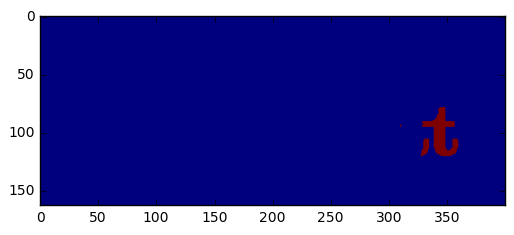

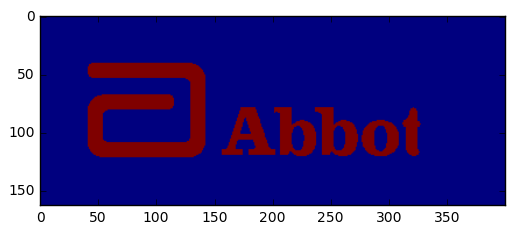

In [17]:
for l in range(np.max(eroded_labels)):
    if eroded_chars[l]:
        marks[morphology.dilation(eroded_labels==l, selem=morphology.disk(5))] = 0
        allchars[morphology.dilation(eroded_labels==l, selem=morphology.disk(3))] = 1

plt.figure()
plt.imshow(marks)

plt.figure()
plt.imshow(allchars)

## Features of the marks

Now, we will take the marks that have been isolated by the above extractor, and compute a set of features describing those marks.

First, let's cluster the marks based on position, and eliminate very small outliers:

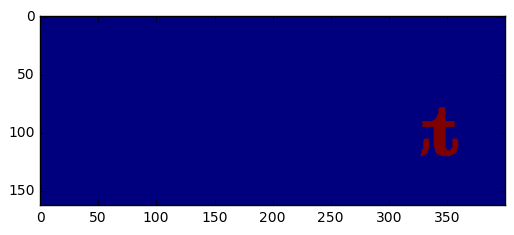

In [18]:
mark_pix = np.transpose(np.vstack(np.where(marks > 0)))

mark_clusters = DBSCAN(algorithm='ball_tree', eps=15, min_samples=1) 
# NOTE: eps is a tuning parameter

mark_clusters.fit(mark_pix)

mark_segments = np.copy(marks)
mark_segments[mark_segments > 0] = mark_clusters.labels_+1

h,w = img.shape[0:2]
img_size = h*w

mark_fracs = np.array([np.sum(mark_segments == s) / img_size for s in range(np.max(mark_segments)+1)])

big_marks = np.zeros_like(mark_segments)
index = 0
for s in range(np.max(mark_segments)+1):
    if mark_fracs[s] > 0.01:
        big_marks[mark_segments==s] = index
        index += 1
        
plt.imshow(big_marks)

These just isolate the parts of the regionalized and original images corresponding to the big marks:

In [19]:
h,w = big_marks.shape
big_marks_regionalized = np.zeros((h,w,np.max(big_marks)))
for m in range(np.max(big_marks)):
    temp = np.copy(regionalized)
    temp[big_marks != m+1] = 0
    big_marks_regionalized[:,:,m] = temp

In [20]:
h,w = big_marks.shape
big_marks_orig = np.zeros((h,w,3,np.max(big_marks))).astype('uint8')
for m in range(np.max(big_marks)):
    temp = np.copy(add_padding(img, bgval=255, pad_size=20))
    temp[big_marks != m+1] = 255
    big_marks_orig[:,:,:,m] = temp

We could print the following to test if it's working:

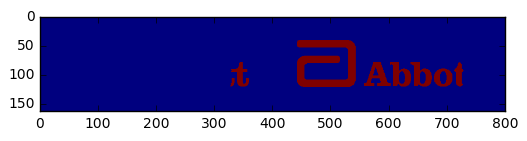

In [21]:
plt.imshow(np.hstack([big_marks, allchars]))

In [22]:
import scipy.misc

scipy.misc.imsave('data/test_extraction/'+name+'.jpg', 1-np.hstack([big_marks, allchars]))

Now, we compute a bunch of descriptors on each of the big marks. I will first demonstrate the extraction on one of the marks, then write a loop that combines everything. I will also point to literature where relevant.

**NOTE: Many of these same feature extractors will be used again when looking at the logo as a whole, where the same justification can be applied.**

First, there is still some final processing that should be done, to compute things later on:

*Compute the location of the characters (this will be used later on):*

In [23]:
chars = np.isin(regionalized-1, np.where(is_char))

h,w = regionalized.shape


h_charfirstp = 0
h_charlastp = w
v_charfirstp = 0
v_charlastp = h

for i in range(w):
    if np.sum(allchars[:,i])>0:
        h_charfirstp = i
        break

for i in reversed(range(w)):
    if np.sum(allchars[:,i])>0:
        h_charlastp = i
        break

for j in range(h):
    if np.sum(allchars[j,:])>0:
        v_charfirstp = j
        break

for j in reversed(range(h)):
    if np.sum(allchars[j,:])>0:
        v_charlastp = j
        break
            
if np.sum(is_char) > 0:
    h_charpos = (h_charfirstp+h_charlastp)/2./w
    v_charpos = (v_charfirstp+v_charlastp)/2./h
else: 
    h_charpos = 0.5
    v_charpos = 0.5

Some basic properties of the mark in question:

In [24]:
m = 1

# Binarized version of the mark:
binmark = (big_marks==m)

# Which of the original regions correspond to this mark?
whichregions = np.unique(regionalized[binmark])

# Mark's fraction of the total image:
frac = np.sum(big_marks==m)/img_size

frac

0.014001806684733513

### Convex hull of the mark:

The convex hull of the mark conveys the sort of "structure" of the mark. This relates to a number of things in the literature, like the predominance of global features over local features (Navon 1977), and the "types" that have been found in package design from the work of Orth and Malkewitz (2008), where they study a bunch of dimensions of package design, including some described below based on Henderson and Cote (2004), but others including size and weight, and position (also described subsequently).

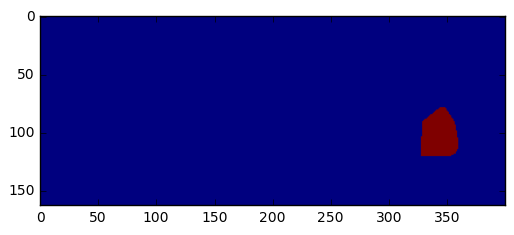

In [25]:
# Convex hull of the mark:
ch = convex_hull_image(binmark)
plt.imshow(ch)

### Complexity of the mark:

In the following chunks, I will extract information about the complexity of the mark. Again, many of these same descriptors will be used for the logo as a whole, so I will not repeat those later when looking at holistic logo properties.

Complexity has been studied in a number of previous papers, starting from Henderson and Cote (1998), where "elaborate" was one of their key dimensions of logo design, with complexity being a subdimension. Note that the other subdimensions were "active" and "depth" which can be approximately captured with other features. Another one of Henderson and Cote's primary dimensions was natural, which is the degree to which the design depicts commonly experienced objects. This is not explicitly captured by complexity (especially given complexity is a subdimension of another one of their constructs), yet natural designs are, in many cases, more "complex" than non-natural ones, especially in logos (think branch of a tree versus a bunch of triangles). Van der Lans et al. use basically the same framework for studying logo design responses. 

Pieters et al. (2010) also study complexity, but in advertising. They come up with two subdimensions of complexity: feature complexity and design complexity. Feature complexity relates to color and edges, which they measure using variance at the pixel level. Design complexity is similar to elaborateness above, and measured by looking at quantity of objects, irregularity of objects, dissimilarity of objects, detail of objects, asymmetry of object arrangement, and irregularity of object arrangement.

Here, we will compute a number of metrics of complexity, providing a proxy to some of these ideas. First, we can look at the number of colors, isolated from the above DBSCAN-based clustering/color quantization:



In [26]:
# Number of colors in the mark:
ncolors = np.unique(feat_cols[whichregions-1], axis=0).shape[0]
ncolors

1

We can also look at features of the mark itself, like how many subcomponents it has, and the perimetric complexity of those components (perimetric complexity is computed from the ratio of the number pixels on the perimeter of the object and the area of the interior; see, for instance, this article from the *Mathematica journal* http://www.mathematica-journal.com/data/uploads/2012/02/Watson.pdf):

In [27]:
# Number of subregions in the mark?
nregions = whichregions.size

# Perimetric complexity of the mark:
pcm = perimetric_complexity(remove_segmentation_bg(binmark).astype("float"))

nregions, pcm

(1, 5.1340304223192046)

We can also study things like the entropy of the mark, and the density of the mark, meaning what percentage of the mark is color versus background. These again get at things like the feature complexity of Pieters et al., the complexity and naturalness of Henderson and Cote, and even at some aspects of color described above, like the ratio of light and dark within the feature. Note that we compute these things WITHIN the convex hull of the feature, to minimize the degree that the background may influence these features (for example, a long ovular feature may have the same complexity as a circular feature, but if everything is shrunk to fit in a square or rectangle, one may have different densities based purely on the amount of background, which is irrelevant to the feature itself).

In [28]:
# Density of the binarized mark within its hull:
ch_density = np.sum(binmark[ch])/np.sum(ch)

ch_density

0.56672760511883002

In [29]:
# Entropy of the greyscale mark within its hull:
graymark = color.rgb2gray(big_marks_orig[:,:,:,0])
ch_entropy = np.mean(entropy(graymark, disk(5))[ch])

ch_entropy

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


1.0516479504235483

### Symmetry

Symmetry has been described by both Henderson and Cote, as a component of harmonious, and likewise by van der Lans et al. Moreover, symmetry is, to some degree, also a property of "parallel", another dimension of van der Lans et al. Thus, we can look within each mark, and compute the degree to which it is vertically and horizontally symmetric, but comparing the correlation between its vertical and horizontal halves (respectively):

In [30]:
# Horizontal, vertical symmetry
h_sym, v_sym = compute_symmetry(binmark)
h_sym, v_sym

(0.60662134693013336, 0.32442445792037994)

### Repetition

Repetition was also described in both Henderson and Cote and van der Lans et al. This proved a little more difficult to operationalize. I have come up with two proxies: the standard deviation of the sizes of the subcomponents of the mark, and the standard deviation of the perimetric complexities of the subcomponents of the mark. The reason being that many similar size subcomponents likely indicates that there is repetition in the mark, so a low standard deviation in sizes (actually, fractions of the total mark) should be indicative of that. Similarly, if two features are similar in nature, *regardless of rotation or size*, they should have similar perimetric complexities.

In [31]:
entropy(graymark, disk(5))[ch]

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


array([ 1.41040249,  1.42515241,  1.42515241, ...,  1.0831794 ,
        1.0831794 ,  1.22139776])

In [32]:
# Repetition metrics:
if nregions > 1:
    rep_frac = np.std([np.sum(regionalized==i)/np.sum(binmark) for i in whichregions])
    rep_pcm = np.std([perimetric_complexity(add_quantized_padding(
        remove_segmentation_bg(regionalized==i),pad_size=5).astype("float")) for i in whichregions])
else:
    rep_frac = 0.
    rep_pcm = 0.

rep_frac, rep_pcm

(0.0, 0.0)

Note that the scales of these are different: the fractions take values between 0 and 1, so we expect this to be very close to zero for subcomponents all of the same size. The complexities take positive values, but not of a restricted range.

### Position of the mark:

Position of the mark both has to do with the actual perception of position, and of the orientation of the logo as a whole. Cian et al. (2014) found that logos can evoke the idea of movement by positioning of the logo elements, and by the horizontal orientation of th elogo, which in turn affects consumers' engagement and attitude. Schlosser et al. (2016) found that upward diagonals convey greater activity than downward diagonals, leading to more favorable evaluations, efficacy beliefs, and post-consumption satisfaction.

In other domains, there is also related work. For example, Chae and Hoegg find that cultures that read left to right also prefer product positioning from left to right. In the packaging literature, Deng and Kahn (2016) find that the location of the product image on packaging influences the item's perceived weight. Earlier, in advertising, Meyers-Levy and Peracchio (1992) found that looking up versus straight on at an ad influences favorability judgments. 

By computing the position of the mark on the logo as a whole, we can get at some of these things. We can also use these measures, relative to the text, to see the orientation of the mark relative to the logo.

In [33]:
# Position of the mark:
h,w = regionalized.shape

h_firstp = 0
h_lastp = w
v_firstp = 0
v_lastp = h

for i in range(w):
    if np.sum(binmark[:,i])>0:
        h_firstp = i
        break

for i in reversed(range(w)):
    if np.sum(binmark[:,i])>0:
        h_lastp = i
        break

for j in range(h):
    if np.sum(binmark[j,:])>0:
        v_firstp = j
        break

for j in reversed(range(h)):
    if np.sum(binmark[j,:])>0:
        v_lastp = j
        break

if np.sum(binmark) > 0:
    h_pos = (h_firstp+h_lastp)/2./w
    v_pos = (v_firstp+v_lastp)/2./h
else: 
    h_pos = 0.5
    v_pos = 0.5

(h_pos, v_pos)

(0.85625, 0.6104294478527608)

### Position of the mark relative to the text

Again speaking to issues of orientation and such, we can compute where the mark is relative to the text. There are two ways to do this: either just compare the average positions of the two (e.g. `h_pos < h_charpos` implies the mark is to the left of the text), or look for absolute position rules (e.g. `h_lastp < h_charfirstp` implies that the entire mark is to the left of all of the characters). I will refer to the first as `avg_left` and the latter as `abs_left`. To assess average position, I will use a cutoff window of 0.2: if the absolute difference between the two mean positions is greater than 0.2, then the condition will be true.

In [34]:
avg_left = False
avg_right = False
avg_top = False
avg_bot = False

abs_left = False
abs_right = False
abs_top = False
abs_bot = False

if (h_charpos - h_pos) > 0.2:
    avg_left = True
elif (h_pos - h_charpos) > 0.2:
    avg_right = True
    
if (v_charpos - v_pos) > 0.2:
    avg_top = True
elif (v_pos - v_charpos) > 0.2:
    avg_bot = True
    
if h_lastp < h_charfirstp:
    abs_left = True
elif h_firstp > h_charlastp:
    abs_right = True
    
if v_lastp < v_charfirstp:
    abs_top = True
elif v_firstp > v_charlastp:
    abs_bot = True

In [35]:
avg_left, avg_right, avg_top, avg_bot

(False, True, False, False)

In [36]:
abs_left, abs_right, abs_top, abs_bot

(False, True, False, False)

In [37]:
v_firstp, v_charlastp

(79, 121)

### Proportion and horizontal orientation

Proportion is another thing that has been studied in Henderson and Cote (1998) and van der Lans (2009): we can operationalize proportion by looking at the aspect ratio of the mark (that is, the ratio of the width to the height). This also speaks, in some way, to horizontal orientation.

In [38]:
# Aspect ratio of the mark:
ar = np.abs(h_firstp-h_lastp)/np.abs(v_firstp-v_lastp)
ar

0.75609756097560976

### Angularity 

Angularity of features is another thing that has been described at length in the literature: Walsh et al. (2010) finds that moving from an angular to a round logo produces mixed responses in consumers, while Jiang et al. find that the mere circularity or angularity of the logo affects perceptions of hardness or softness. We can operationalize angularity via the number of corners:

In [39]:
# Number of corners in the mark:
ncorners = feature.corner_peaks(feature.corner_harris(binmark)).shape[0]
ncorners

20

### Orientation and diagonals

Several papers have discussed the idea of conveying movement: Cian et al., discussed already above, finds that a horizontal orientation can affect consumers evaluations. More recently, Schlosser at al. (2016) finds that upward diagonals convey greater activity, leading to differences in evaluations of the logo.

In this section, we try to more generally capture directionality or orientation, using the gradients of the image, to characterize the percentage of edge pixels falling in one of four buckets: downward diagonal, vertical, upward diagonal, horizontal.

In [40]:
# Gradient information to capture orientation:
grad_mean, grad_bins = gradient_info(binmark)
(down_diag, vert, up_diag, hor) = grad_bins
grad_bins

array([ 0.05989583,  0.515625  ,  0.12239583,  0.30208333])

## Combining and saving all of the mark features: 

In [41]:
marks = pd.DataFrame()
mark_features = pd.DataFrame()
mark_hulls = pd.DataFrame()

for m in (np.arange(np.max(big_marks))+1):

    # Binarized version of the mark:
    binmark = (big_marks==m)
    
    # Save the mark:
    std_mark = make_small_feature(remove_segmentation_bg(binmark), end_size = 25)
    mark_df = pd.DataFrame(np.reshape(make_small_feature(remove_segmentation_bg(binmark), end_size = 25), (1,(25*25))))
    mark_df.insert(0, 'name', name)
    mark_df.insert(1, 'index', m)
    marks = pd.concat([marks, mark_df])
    
    # Which of the original regions correspond to this mark?
    whichregions = np.unique(regionalized[binmark])
    
    # Bumber of colors in the mark:
    ncolors = np.unique(feat_cols[whichregions-1], axis=0).shape[0]
    
    # Number of subregions in the mark?
    nregions = whichregions.size
    
    # Mark's fraction of the total image:
    frac = np.sum(big_marks==m)/img_size
    
    # Perimetric complexity of the mark:
    pcm = perimetric_complexity(remove_segmentation_bg(binmark).astype("float"))
    
    # Horizontal, vertical symmetry
    h_sym, v_sym = compute_symmetry(binmark)
    
    # Repetition metrics:
    if nregions > 1:
        rep_frac = np.std([np.sum(regionalized==i)/np.sum(binmark) for i in whichregions])
        rep_pcm = np.std([perimetric_complexity(add_quantized_padding(
            remove_segmentation_bg(regionalized==i),pad_size=5).astype("float")) for i in whichregions])
    else:
        rep_frac = 0.
        rep_pcm = 0.
        
    # Position of the mark:
    h,w = regionalized.shape
    
    ## horizontal position:
    for i in range(w):
        if np.sum(binmark[:,i])>0:
            h_firstp = i
            break

    for i in reversed(range(w)):
        if np.sum(binmark[:,i])>0:
            h_lastp = i
            break
            
    h_pos = (h_firstp+h_lastp)/2./w

    ## vertical position:
    for j in range(h):
        if np.sum(binmark[j,:])>0:
            v_firstp = j
            break
            
    for j in reversed(range(h)):
        if np.sum(binmark[j,:])>0:
            v_lastp = j
            break

    v_pos = (v_firstp+v_lastp)/2./h
    
    # Relative position:
    avg_left = False
    avg_right = False
    avg_top = False
    avg_bot = False

    abs_left = False
    abs_right = False
    abs_top = False
    abs_bot = False

    if (h_charpos - h_pos) > 0.2:
        avg_left = True
    elif (h_pos - h_charpos) > 0.2:
        avg_right = True

    if (v_charpos - v_pos) > 0.2:
        avg_top = True
    elif (v_pos - v_charpos) > 0.2:
        avg_bot = True

    if h_lastp < h_charfirstp:
        abs_left = True
    elif h_firstp > h_charlastp:
        abs_right = True

    if v_lastp < v_charfirstp:
        abs_top = True
    elif v_firstp > v_charlastp:
        abs_bot = True
    
    # Convex hull of the mark:
    ch = convex_hull_image(binmark)
    
    # Save the convex hull:
    ch_df = pd.DataFrame(np.reshape(make_small_feature(remove_segmentation_bg(ch), end_size = 25), (1,25*25)))
    ch_df.insert(0, 'name', name)
    ch_df.insert(1, 'index', m)
    mark_hulls = pd.concat([mark_hulls, ch_df])
    
    # Density of the mark within its hull:
    ch_density = np.sum(binmark[ch])/np.sum(ch)
    
    # Entropy of the mark within its hull:
    ch_entropy = np.mean(entropy(binmark, disk(5))[ch])

    # Aspect ratio of the mark:
    ar = np.abs(h_firstp-h_lastp)/np.abs(v_firstp-v_lastp)
    
    # Number of corners in the mark:
    ncorners = feature.corner_peaks(feature.corner_harris(binmark)).shape[0]
    
    # Gradient information to capture orientation:
    grad_mean, grad_bins = gradient_info(binmark)
    (down_diag, vert, up_diag, hor) = grad_bins
    
    features_df = pd.DataFrame({'name':name,
                                'index':m,
                                'ncolors':ncolors,
                                'nregions':nregions,
                                'frac':frac,
                                'pcm':pcm,
                                'h_sym':h_sym,
                                'v_sym':v_sym,
                                'rep_frac':rep_frac,
                                'rep_pcm':rep_pcm,
                                'h_pos':h_pos,
                                'v_pos':v_pos,
                                'avg_left':avg_left,
                                'avg_right':avg_right,
                                'avg_top':avg_top,
                                'avg_bot':avg_bot,
                                'abs_left':abs_left,
                                'abs_right':abs_right,
                                'abs_top':abs_top,
                                'abs_bot':abs_bot,
                                'ch_density':ch_density,
                                'ch_entropy':ch_entropy,
                                'ar':ar,
                                'ncorners':ncorners,
                                'down_diag':down_diag,
                                'vert':vert,
                                'up_diag':up_diag,
                                'hor':hor}, 
                              index=[m], 
                              columns=['name','index','ncolors','nregions',
                                       'frac','pcm','h_sym','v_sym','rep_frac', 
                                       'rep_pcm','h_pos','v_pos',
                                       'avg_left','avg_right','avg_top','avg_bot',
                                       'abs_left','abs_right','abs_top','abs_bot',
                                       'ch_density','ch_entropy','ar','ncorners',
                                       'down_diag','vert','up_diag','hor'])
    mark_features = pd.concat([mark_features,features_df])

In [42]:
mark_features

,name,index,ncolors,nregions,frac,pcm,h_sym,v_sym,rep_frac,rep_pcm,...,abs_top,abs_bot,ch_density,ch_entropy,ar,ncorners,down_diag,vert,up_diag,hor
1,abbott-labs,1,1,1,0.014002,5.13403,0.606621,0.324424,0,0,...,False,False,0.566728,0.780712,0.756098,20,0.059896,0.515625,0.122396,0.302083


In [43]:
marks

,name,index,0,1,2,3,4,5,6,7,...,615,616,617,618,619,620,621,622,623,624
0,abbott-labs,1,0,0,0,0,0,0,0,0,...,1,1,1,0.55,0.222987,0,0,0,0,0


In [44]:
mark_hulls

,name,index,0,1,2,3,4,5,6,7,...,615,616,617,618,619,620,621,622,623,624
0,abbott-labs,1,0,0,0,0,0,0,0,0,...,1,1,1,0.55,0.222987,0,0,0,0,0


## Global Features

Having both assessed the features of the fonts and of the marks, let's now compute some metrics for the logo as a whole. Many of these metrics will be similar to those used to assess the marks, and with similar justifications as above, so I will not repeat them here.

To begin, we will look at summaries of the metrics computed above, to capture complexity, like how many marks there are, how many letters, how many regions, and how many distinct colors:

In [45]:
ncolors = color_df.shape[0]
ncolors

4

In [46]:
nmarks = marks.shape[0]
nmarks

1

In [47]:
nregions = np.max(regionalized)
nregions

6

We can also use the greyscale of the logo to compute metrics similar to the above, things like the entropy and perimetric complexity as a measures of complexity,

In [48]:
# Compute greyscale summaries:
grey_img = color.rgb2grey(img)

# Average local greyscale entropy:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grey_entropy = np.mean(entropy(remove_white_bg(grey_img), disk(20)))

# Perimetric complexity:
binary_img = (grey_img < 0.9).astype("float")
gpc = perimetric_complexity(binary_img)

grey_entropy, gpc

(1.4043095209572871, 27.985170646553495)

Again, to assess angularity, the number of corners (this time with an illustration):

In [49]:
# Total number of corners in the img:
ncorners = feature.corner_peaks(feature.corner_harris(grey_img), min_distance=5).shape[0]
ncorners

33

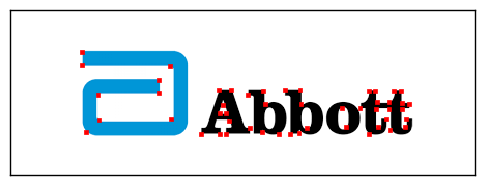

In [50]:
coords = feature.corner_peaks(feature.corner_harris(binary_img), min_distance=5)

fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.r', markersize=7)
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

As mentioned above, some work by Valdez and Mehrabian, as well as by Deng et al., shows that people have different reactions to the HSV dimensions. One easy statistic to compute, though may not be particularly useful, is the average HSV dimensions for the image as a whole (giving a notion of, for example, on average how light are the colors used, or how saturated---hue probably doesn't mean anything), or how variable saturation and lightness are across the image.

In [51]:
# HSV summaries:
hsv_img = color.rgb2hsv(remove_white_bg(img))
hsv_means = np.mean(hsv_img, axis=(0,1))
mean_sat = hsv_means[1]
mean_light = hsv_means[2]

hsv_sds = np.std(hsv_img, axis=(0,1))
sd_sat = hsv_sds[1]
sd_light = hsv_sds[2]

mean_sat, mean_light, sd_sat, sd_light

(0.17633535008536785,
 0.80620673871959447,
 0.37462038654502156,
 0.35364361048028231)

Another metric of lightness (and perhaps of complexity) is the percentage of whitespace:

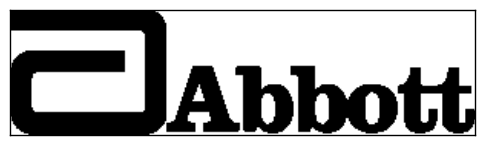

In [52]:
plt.imshow(1-remove_segmentation_bg(binary_img), cmap="gray")
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                labelbottom='off', right='off', left='off', labelleft='off')

In [53]:
perc_white = 1.0 - np.mean(remove_segmentation_bg(binary_img))
perc_white

0.6057846598202824

We can also compute the symmetry of the logo as a whole:

In [54]:
# Horizontal, vertical symmetry
h_sym, v_sym = compute_symmetry(binary_img)
h_sym, v_sym

(0.014511323699310548, 0.16545682646165241)

The aspect ratio of the logo as a whole:

In [55]:
# Aspect ratio of the mark:
h,w = remove_segmentation_bg(regionalized).shape
ar = w/h
ar

3.7037037037037037

Global orientation and diagonals:

In [56]:
# Gradient information to capture orientation:
grad_mean, grad_bins = gradient_info(binary_img)
(down_diag, vert, up_diag, hor) = grad_bins
grad_bins

array([ 0.07538995,  0.39745812,  0.08001155,  0.44714038])

Two things are worth noticing at this point:

1. I think this measure for the logo as a whole is not as meaningful as it was for the mark in isolation, since many of the letters themselves have strong upward gradients

2. Many of the local mark features can also be made into global features: for example, if there is only one mark, and it is to the left of the text versus the right of the text. This captures, to some degree, the orientation. If there is more than one mark (or some missed text that is captured as a "mark"), then we should decide the orientation based on the main mark.

Thus, following up on point 2, we have another measure of orientation, looking at where the main (alt. max) mark (shortened as `mmark`) falls relative to the text:

In [57]:
(mmark_avgleft, mmark_avgright, mmark_avgtop, mmark_avgbot, mmark_absleft, mmark_absright, mmark_abstop, 
 mmark_absbot) = mark_features.iloc[mark_features['frac'].idxmax()-1,:].loc['avg_left':'abs_bot']

(mmark_avgleft, mmark_avgright, mmark_avgtop, mmark_avgbot, mmark_absleft, mmark_absright, mmark_abstop, 
 mmark_absbot)

(False, True, False, False, False, True, False, False)

Finally, we can still compute the hull and all of that:

(-0.5, 359.5, 122.5, -0.5)

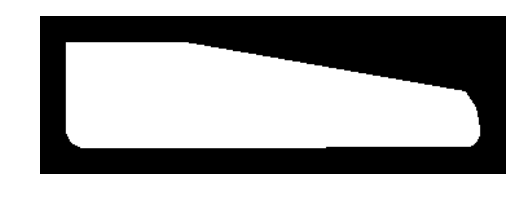

In [58]:
hull = make_small_feature(convex_hull_image(binary_img))

plt.figure()
plt.imshow(convex_hull_image(binary_img), cmap="gray")
plt.axis('off')

Computing the hull lets us group logos by their structure, and may capture again something similar to orientation.

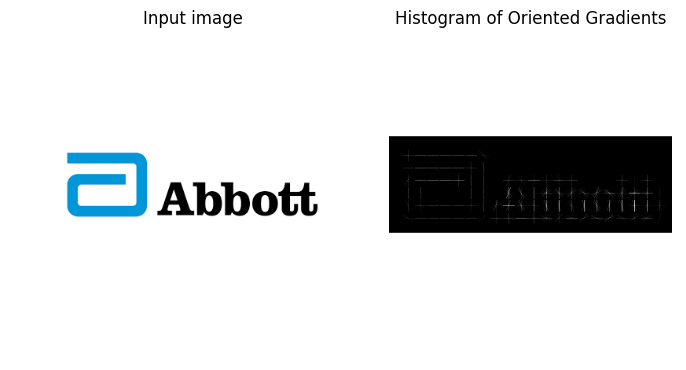

In [59]:
from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(grey_img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

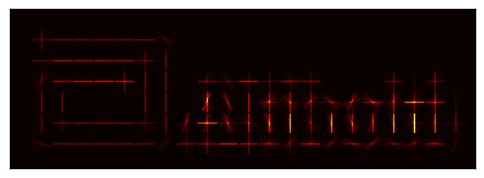

In [60]:
plt.imshow(hog_image_rescaled, cmap="hot")
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                labelbottom='off', right='off', left='off', labelleft='off')